---
# Web scraping Indeed.com to predict salaries
### Oliver Sildmäe

---

## Problem statement and goal

This project was undertaken primarily to practise web scraping for data.

First, Indeed.com will be scraped to obtain salary information on data science jobs across various US cities. Then, using the location, title and summary of the job we will attempt to predict the salary of jobs based on these features. 

While most listings on Indeed.com do not have salary information, being able to accurately extrapolate or predict the expected salaries from other listings would be extremely useful for job listing sites, providing extremely important additional information to their users.

## Imports and settings

In [ ]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import re

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import precision_recall_curve

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
sns.set(font_scale=1.5)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Scraping job listings from Indeed.com with Beautifulsoup

To obtain a first look at how the page is structured, the `requests` package imported above is used to setup a request to the URL below. BeautifulSoup is then used  to parse the page and extract all results

The test URL below has a number of query parameters:<br>
https://www.indeed.com/jobs?q=data+scientist+$20,000&l=New+York&start=10

- `q` stands for the job search
- This is followed by 'data+scientist', inputting the words as a search term
- This is followed by "+20,000" to return results with salaries (or expected salaries >$20,000)
- `l` stands for a location, with 'New+York' specifying the location for this search
- `start` is used to define  what result number to start on (e.g. '00' for page 1, '10' for page 2, etc.)

An example extracted result is dsplayed below:

```
<div class=" row result" data-jk="2480d203f7e97210" data-tn-component="organicJob" id="p_2480d203f7e97210" itemscope="" itemtype="http://schema.org/JobPosting">
<h2 class="jobtitle" id="jl_2480d203f7e97210">
<a class="turnstileLink" data-tn-element="jobTitle" onmousedown="return rclk(this,jobmap[0],1);" rel="nofollow" target="_blank" title="AVP/Quantitative Analyst">AVP/Quantitative Analyst</a>
</h2>
<span class="company" itemprop="hiringOrganization" itemtype="http://schema.org/Organization">
<span itemprop="name">
<a href="/cmp/Alliancebernstein?from=SERP&amp;campaignid=serp-linkcompanyname&amp;fromjk=2480d203f7e97210&amp;jcid=b374f2a780e04789" target="_blank">
    AllianceBernstein</a></span>
</span>
<tr>
<td class="snip">
<nobr>$117,500 - $127,500 a year</nobr>
<div>
<span class="summary" itemprop="description">
C onduct quantitative and statistical research as well as portfolio management for various investment portfolios. Collaborate with Quantitative Analysts and</span>
</div>
</div>
</td>
</tr>
</table>
</div>
```

While this has some more verbose elements removed, we can see that there is some structure to the above:
- The salary is available in a `nobr` element inside of a `td` element with `class='snip'`.
- The title of a job is in a link with class set to `jobtitle` and a `data-tn-element='jobTitle'`.  
- The location is set in a `span` with `class='location'`. 
- The company is set in a `span` with `class='company'`. 

#### Writing functions to extract each item of interest: location, company, job, and salary

In [ ]:
# Will return, from the soup specified in the 'result' input, the data specified in the 'item' input.
## This function will be part of a larger function below, one that will loop through various 'result'
## and 'item' input combinations

def extract_from_soup(result, item):
    # Four cases for each of the data types we're interested in (location, salary, company, job title)
    if item == 'location':
        try:
            return result.find('span', class_='location').text
        except:
            return 'None found'
    if item == 'salary':
        try:
            return result.find('td', class_='snip').find('span', class_='no-wrap').text.strip()
        except:
            return 'None found'
    if item == 'company':
        try:
            return result.find('span', class_='company').text.strip()
        except:
            return 'None found'
    if item == 'job':
        try:
            return result.find('h2', class_ = "jobtitle").find('a').get('title')
        except:
            return 'None found'

In [260]:
# Manually testing the function above with a specified result
url = "https://www.indeed.com/jobs?q=data+scientist+$20,000&l=New+York&start=00"
r = requests.get(url)
soup = BeautifulSoup(r.text, 'html.parser')
test_result = soup.find_all('div', attrs={'data-tn-component':'organicJob'})

# Testing the function. Looping through the 10 job listings on the specified Indeed.com page and
# extracting the company name from each of them.
for i in test_result:
    print(extract_from_soup(i, 'company'))

#Results below:

IBM
HBO
Callière Group
S&P Global Ratings
DEPT OF INFO TECH & TELECOMM
Dow Jones
Alliant Insight
Smartly
Viacom
Alliant Insight


#### Doing the big scrape for all listings we'll need

In [7]:
results = []
failures = []

# Specifying the cities which will be searched and looping through each of them
for city in set(['New+York', 'Chicago', 'San+Francisco', 'Austin', 'Seattle', 
                'Los+Angeles', 'Philadelphia', 'Atlanta', 'Dallas', 'Pittsburgh', 
                'Portland', 'Phoenix', 'Denver', 'Houston', 'Miami', 'Honolulu']):
    
    # Setting the maximum results per city to the amount of jobs on the website in given city
    # (if not done, it will keep reloading and replicating the last page for each city ad infinitum)
    r = requests.get(F'http://www.indeed.com/jobs?q=data+scientist+$20,000&l={city}&start=00')
    soup = BeautifulSoup(r.text, 'html.parser')
    max_results_per_city = soup.find('div', attrs = {'id':'searchCount'}).text
    max_results_per_city = max_results_per_city.split(' ')
    max_results_per_city = int(max_results_per_city[-2].replace(',',''))
    
    # If more than 1000 results per city, set the limit at 1000 to save time scraping
    # (this step should be ignored if there's interst in more than 1000 listings per city)
    if max_results_per_city > 1000:
        max_results_per_city = 1000
    
    for start in range(0, max_results_per_city, 10):
        # Loop through the limit of results defined for each city above, swapping 'city' and
        # 'start' at each iteration
        URL = F'http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l={city}&start={start}'
        try:
            r = requests.get(URL)
            soup = BeautifulSoup(r.text, 'html.parser')
            # Append to the full set of results
            results.append(soup)
        except: 
            # If failure, keep a list of failed URLS (append)
            failures.append(r)
            
    # Print city name to keep track of scraping progress
    print(f'{city} done...')
print('ALL DONE')    

Chicago done...
Miami done...
Philadelphia done...
Seattle done...
San+Francisco done...
Los+Angeles done...
Austin done...
Pittsburgh done...
Denver done...
Phoenix done...
Portland done...
Houston done...
Atlanta done...
Dallas done...
Honolulu done...
New+York done...
ALL DONE


#### Using the function defined above to parse out the four fields of interest - location, title, company and salary - from the results just scraped

In [49]:
jobs = []
salaries = []
locations = []
companies = []

for i in range(len(results)):
    # Every iteration at this level is a single page scraped - will have (up to) 10 job listings
    sub_results = results[i].find_all('div', attrs={'data-tn-component':'organicJob'})
    
    for j in sub_results:
        # Every iteration at this level is a single job listing. The function from above is used
        # to extract the information of interest.
        jobs.append(extract_from_soup(j, 'job'))
        salaries.append(extract_from_soup(j, 'salary'))
        locations.append(extract_from_soup(j, 'location'))
        companies.append(extract_from_soup(j, 'company'))

In [50]:
#. Create a dataframe from the results with the four variables of interest.
df = pd.DataFrame({'job':jobs, 'location':locations, 'company':companies, 'salary':salaries})

In [57]:
df.shape
# 8046 jobs listings scraped in total

(8046, 4)

In [61]:
df.head()
# A look at some of the listings:

,job,location,company,salary
0,Data Scientist,"Chicago, IL","Blue Cross Blue Shield of IL, MT, NM, OK & TX",None found
1,Senior Data Scientist,"Chicago, IL","Blue Cross Blue Shield of IL, MT, NM, OK & TX",None found
2,Pricing & Promotions Data Scientist,"Chicago, IL 60654 (Loop area)",Groupon,None found
3,Data Scientist,"Schaumburg, IL 60173",Zurich North America,None found
4,Data Scientist,"Chicago, IL",The University of Chicago,None found


#### Cleaning the data obtained
<br>
Potential issues:
1. Just a small number of the scraped results have salary information - only these will be used for modeling.
1. Some of the salaries are not yearly but hourly or weekly, these will not be useful to us for now.
1. Some of the entries may be duplicated.
1. The salaries are given as text and usually with ranges.

#### Extract the salary figures from the 'salary' column string fields and convert them to integers, averaging the figures if they are presented as a range

In [69]:
# Making a copy of the first dataframe to ensure I won't overwrite it with any mistakes
## Subset for rows with have the string 'year' in the 'salary' column
df2 = df.copy()[df.salary.str.contains('year')]
df2.reset_index(inplace=True, drop=True)

In [ ]:
# Dropping duplicate rows
df2.drop_duplicates(inplace=True)
df2.reset_index(inplace=True, drop=True)

In [75]:
df2.shape
# 371 listings after subsetting and the duplicates have been removed

(371, 4)

In [73]:
df2.head(3)
# Sample of listings in the subset

,job,location,company,salary
0,Mid Level Data Scientist (Regression/Visualiza...,"Chicago, IL",Jobspring Partners,"$95,000 - $115,000 a year"
1,Data Scientist,"Chicago, IL",S.C. International,"$100,000 a year"
2,Data Scientist,"Chicago, IL",Jobspring Partners,"$90,000 - $120,000 a year"


In [ ]:
# Writing a function that takes a salary string and converts it to a number, averaging a salary 
# range if necessary

# Removing commas from the annual salaries
df2.salary = df2.salary.str.replace(',','')

df2['salary_final'] = 0
df3 = df2.copy()

for i in range(len(df2)):
    try:
        # For each row, create a list of figures that are found in the 'salary' column
        salary_figs = re.findall('\d+', df2.salary.iloc[i])
        
        if len(salary_figs) == 1:
            # If only a single figure is found, convert it to integer and save to 'salary_final' column
            df3.salary_final[i] = int(salary_figs[0])        
        elif len(salary_figs) == 2:
            # If two figures are found, convert to integer and save their mean to 'salary_final'   
            df3.salary_final[i] = int((int(salary_figs[0]) + int(salary_figs[1]))/2)
        else:
            # If there's for some reason more than three figures, file a warning
            df3.salary_final[i].iloc = 'inspect this row'
    except:
        # Print the row numbers for salaries that caused issues
        print(i)

In [190]:
# Confirming that the final salary column consists solely integers
df3.dtypes

job             object
location        object
company         object
salary          object
salary_final     int64
dtype: object

#### Saving the results to a CSV file

In [195]:
# Dropping the old and now obsolete 'salary' field
df3.drop('salary', axis=1, inplace = True)

df3.to_csv('indeed_jobs.csv', index=False)

## Predicting salaries using the scraped data

#### Loading in the the data of scraped salaries

In [40]:
# Read in data from the previously saved CSV file
ds_jobs = pd.read_csv('./indeed_jobs.csv')

In [46]:
ds_jobs.head()

,city,company,location,title,salary_final
0,Philadelphia,Workbridge Associates,"Philadelphia, PA",Data Scientist (statistical modeling with insu...,107500
1,Philadelphia,Workbridge Associates,"Mount Laurel, NJ",Python Developer/Data Scientist,115000
2,Philadelphia,Workbridge Associates,"Wilmington, DE",Data Scientist (Statistical Modeling),97500
3,Philadelphia,Workbridge Associates,"Wilmington, DE","Data Scientist (Hadoop, SAS, R, Python)",95000
4,Philadelphia,City of Philadelphia,"Philadelphia, PA",Police Forensic Science Technician,41696


For the sake of simplicity, the problem at hand will be approached as a binary classification. We want to predict a binary variable - whether the salary was low or high.  While performing regression may be better, performing classification may help remove some of the noise of the extreme salaries.

In [48]:
ds_jobs.salary_final.describe()
# Median salary is 114500 (USD)

count       409.000000
mean     112141.068460
std       39629.513517
min       32945.000000
25%       79249.000000
50%      114500.000000
75%      137500.000000
max      300000.000000
Name: salary_final, dtype: float64

In [49]:
# Creating a dummy variable (salary_high) that is True if the salary is above sample median
ds_jobs['salary_high'] = 0
ds_jobs['salary_high'] = (ds_jobs['salary_final'] >= ds_jobs['salary_final'].median())

# Drop the now-reduntant 'salary-final' column
ds_jobs.drop('salary_final', axis=1, inplace=True)

In [53]:
ds_jobs.head(2)

,city,company,location,title,salary_high
0,Philadelphia,Workbridge Associates,"Philadelphia, PA",Data Scientist (statistical modeling with insu...,False
1,Philadelphia,Workbridge Associates,"Mount Laurel, NJ",Python Developer/Data Scientist,True


### Model taking into account job levels and categories

#### Calculating the baseline accuracy for this model

In [51]:
ds_jobs.salary_high.sum()/len(ds_jobs.salary_high)
# The baseline accuracy is:

0.5012224938875306

#### Creating new variables based on job titles

In [57]:
# Split the dependent and independent variables
y = ds_jobs.pop('salary_high')
x = ds_jobs.copy()

In [75]:
# loop through all rows, flagging column 'senior_role' as 1 if column 'title' contains the words
# 'senior' or 'manager'

x['senior_role'] = 0
for i in range(len(x)):
    try:
        seniority = 0
        if len(re.findall('senior',x.title.iloc[i].lower())) != 0:
            seniority = 1
        elif len(re.findall('manager',x.title.iloc[i].lower())) != 0:
            seniority = 1
        else:
            seniority = 0
        x.senior_role[i] = seniority
    except:
        print(i);

In [76]:
# loop through all rows, flagging column 'supersenior_role' as 1 if column 'title' contains the words
# 'president', 'executive', 'director'

x['supersenior_role'] = 0
for i in range(len(x)):
    try:
        seniority = 0
        if len(re.findall('president',x.title.iloc[i].lower())) != 0:
            seniority = 1
        elif len(re.findall('executive',x.title.iloc[i].lower())) != 0:
            seniority = 1
        elif len(re.findall('director',x.title.iloc[i].lower())) != 0:
            seniority = 1
        else:
            seniority = 0
        x.supersenior_role[i] = seniority
    except:
        print(i);

In [77]:
# loop through all rows, flagging column 'junior_role' as 1 if column 'title' contains the words
# 'junior' or 'intern'

x['junior_role'] = 0
for i in range(len(x)):
    try:
        jun = 0
        if len(re.findall('junior',x.title.iloc[i].lower())) != 0:
            jun = 1
        elif len(re.findall('intern',x.title.iloc[i].lower())) != 0:
            jun = 1
        else:
            jun = 0
        x.junior_role[i] = jun
    except:
        print(i);

In [78]:
# loop through all rows, flagging column 'ml' as 1 if column 'title' contains the words
# 'deep' or 'machine', indicating that the job involves aspects of machine learning

x['ml'] = 0
for i in range(len(x)):
    try:
        ml = 0
        if len(re.findall('deep',x.title.iloc[i].lower())) != 0:
            ml = 1
        elif len(re.findall('machine',x.title.iloc[i].lower())) != 0:
            ml = 1
        else:
            ml = 0
        x.ml[i] = ml
    except:
        print(i);

In [79]:
# loop through all rows, flagging column 'engineer' as 1 if column 'title' contains the word 'engineer'

x['engineer'] = 0
for i in range(len(x)):
    try:
        eng = 0
        if len(re.findall('engineer',x.title.iloc[i].lower())) != 0:
            eng = 1
        else:
            eng = 0
        x.engineer[i] = eng
    except:
        print(i);

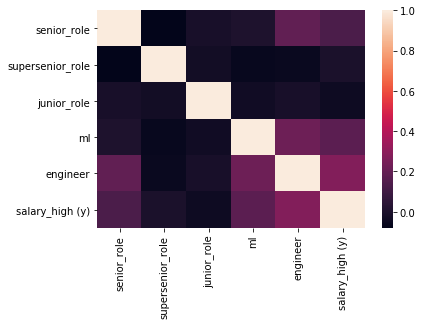

In [82]:
# Creating a heatmap to examine the correlations between the various 

corr_subset = x[['senior_role', 'supersenior_role', 'junior_role', 'ml', 'engineer']]
corr_subset['salary_high (y)'] = y

sns.heatmap(corr_subset.corr());

In [ ]:
# The variables 'supersenior_role' and 'junior_role' have almost non-existent correlations with
# (high) salaries, so they will be excluded from the analyses

x.drop(['city','ml', 'engineer', 'senior_role'], axis = 1, inplace = True)

In [84]:
# Create a dummy variable for each city
x_dum = pd.get_dummies(x, drop_first=True)

In [85]:
# Test/train split the data with a 1:4 ratio, stratifying the dependent variable
x_train, x_test, y_train, y_test = train_test_split(x_dum, y, test_size = 0.2, 
                                                    random_state=1, stratify=y, shuffle = True)

Note: re-scaling is not necessary here as all variables are already in the same binary scale

#### Logistic regression

In [86]:
# Create a logistic regression model (ridge penalty was also tested but lasso performed better)
model = LogisticRegression(penalty='l1')

In [87]:
# Calculating the 5-fold cross-validated training set accuracy score
print(cross_val_score(model, x_train, y_train, cv=5).mean())

0.6483143939393939


In [88]:
# Calculating the test set accuracy score 
model.fit(x_train, y_train)
model.score(x_test, y_test)

0.6341463414634146

In [89]:
# Model coefficients for the above model:
model_coefs = pd.DataFrame(model.coef_)
model_coefs.columns = x_train.columns
model_coefs

,ml,engineer,city_Austin,city_Boston,city_Chicago,city_Dallas,city_Denver,city_Houston,city_Los+Angeles,city_Miami,city_New+York,city_Philadelphia,city_Phoenix,city_Pittsburgh,city_Portland,city_San+Francisco,city_Seattle
0,1.063305,1.085908,-1.058683,0.99656,0.09739,0.0,-0.928365,-0.341484,0.0,-2.411872,-0.504197,0.034454,0.0,0.0,-0.148364,0.606886,1.191704


Surprisingly, including a dummy variable that distinguishes between senior roles by looking for the phrases 'senior', 'manager', 'president', 'executive' or 'director' in the job title did not improve model performance on test data. this is likely to exist due to some terms which indicate seniority not being captured by this mask.

#### Random Forest classifier

In [90]:
# Creating a Random Forest classifier model with default hyperparameters
model = RandomForestClassifier(random_state=1)
model.fit(x_train, y_train)

print(cross_val_score(model, x_train, y_train, cv=3).mean())
print(model.score(x_test, y_test))

# 3-fold cross-validated average accuracy score on training set above, test set accuracy below:

0.651607821332592
0.6707317073170732


In [91]:
# Getting the feature importances for the above random forest model
model_fi = np.transpose(pd.DataFrame(model.feature_importances_))
model_fi = pd.DataFrame(model_fi)
model_fi.columns = x_train.columns

In [92]:
model_fi

,ml,engineer,city_Austin,city_Boston,city_Chicago,city_Dallas,city_Denver,city_Houston,city_Los+Angeles,city_Miami,city_New+York,city_Philadelphia,city_Phoenix,city_Pittsburgh,city_Portland,city_San+Francisco,city_Seattle
0,0.115298,0.199629,0.074852,0.043634,0.028255,0.018225,0.054695,0.054706,0.019468,0.076202,0.087692,0.019027,0.021342,0.011896,0.030261,0.081494,0.063324


The higher the above feature importance, the more closely related with the dependent variable these variables are, explaining more of the variation in Y. 

'ml' (whether the job title includes the phrases 'machine/deep learning') and 'engineer' (whether the job title includes the word 'engineer) are the most important features in this model, indicating that in this dataset, skills are more important at identifying high-paid jobs than cities are. Out of the cities in this model, New York (0.087692) is the most important.

This model performed better than the logistic regression above, on both the training and test data-sets, so it will be used going forward.

#### Optimising Random Forest models' hyperparameters

In [94]:
# Running a cross-validated gridsearch for Random Forests, varying both the amount of folds in the 
# gridsearch and the number of estimators and criteria in the models

kfolds = range(2,10)
model = RandomForestClassifier(random_state=1)

# Specifying the hyperparameters that will be tested
params = {'n_estimators': list(range(1, 40)),
          'criterion': ['gini','entropy']}

for i in kfolds:
    gs = GridSearchCV(model, param_grid=params, cv=i)
    gs.fit(x_train, y_train)
    model = gs.best_estimator_
    kfs = model.score(x_test, y_test)
    print(f'Test score at {i} folds: {kfs}')

Test score at 2 folds: 0.6463414634146342
Test score at 3 folds: 0.6707317073170732
Test score at 4 folds: 0.6097560975609756
Test score at 5 folds: 0.6463414634146342
Test score at 6 folds: 0.6707317073170732
Test score at 7 folds: 0.6463414634146342
Test score at 8 folds: 0.6829268292682927
Test score at 9 folds: 0.6463414634146342


In [95]:
# Re-running the model with the best score from above

model = RandomForestClassifier(random_state=1)
params = {'n_estimators': list(range(1, 40)),
          'criterion': ['gini','entropy']}

# Setting the 'cv' argument at 8, as eight folds performed best above
gs = GridSearchCV(model, param_grid=params, cv=8)
gs.fit(x_train, y_train)
model = gs.best_estimator_
kfs = model.score(x_test, y_test)

print(model)
print(f'Training score: {model.score(x_train, y_train)}')
print(f'Test score: {model.score(x_test, y_test)}')

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)
Training score: 0.691131498470948
Test score: 0.6829268292682927


This model is already pretty good, correctly classifying high and low-paying jobs over 68% of time. This is a considerable improvement over the baseline of about 0.501

## Minimising the false positive rate

#### Drawing the ROC curve to decide a good threshold between the true and false positive rates

We are here interesting in examining the ROC and precision-recall curves to find a good model threshold for classifying high-paid jobs. I am looking to have a reasonably small false positive rate, as it would be (from the point of view of Indeed.com) a lot bigger of a mistake to accidentally classify a low-paying job as a high-paying one than the other way around.

In [96]:
# Getting prediction probabilities and predictions for the above best model
yhat_pp = model.predict_proba(x_test)
yhat = model.predict(x_test)

In [97]:
# Getting the  
fpr, tpr, threshold = roc_curve(y_test, yhat_pp[:, 1])
roc_auc = auc(fpr, tpr)

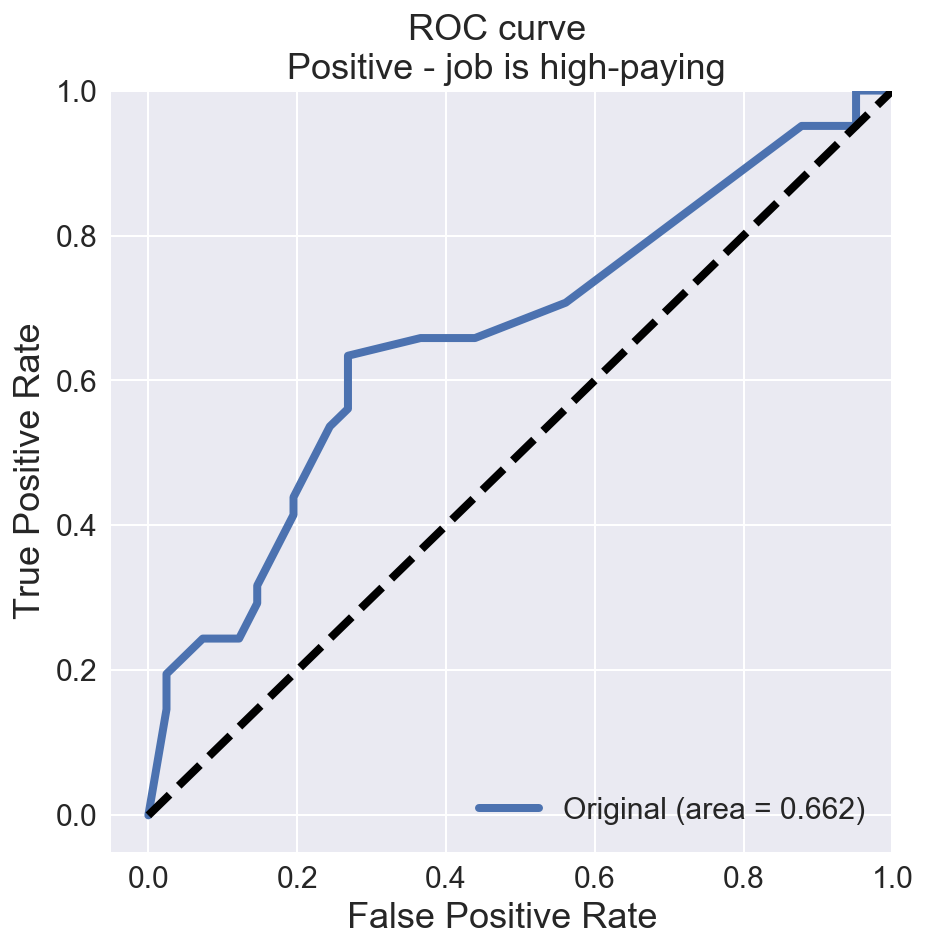

In [115]:
# Drawing the ROC curve

fig, ax = plt.subplots(figsize=(7, 7))

# Plotting the false and true positive rates from above
ax.plot(fpr, tpr, label='Original (area = %0.3f)' % roc_auc, linewidth=4)
ax.plot([0, 1], [0, 1], 'k--', linewidth=4)

ax.set_xlim([-0.05, 1.0])
ax.set_ylim([-0.05, 1.0])
ax.set_xlabel('False Positive Rate', fontsize=18)
ax.set_ylabel('True Positive Rate', fontsize=18)
ax.set_title('ROC curve \n Positive - job is high-paying', fontsize=18)
ax.legend(loc="lower right")

plt.show()

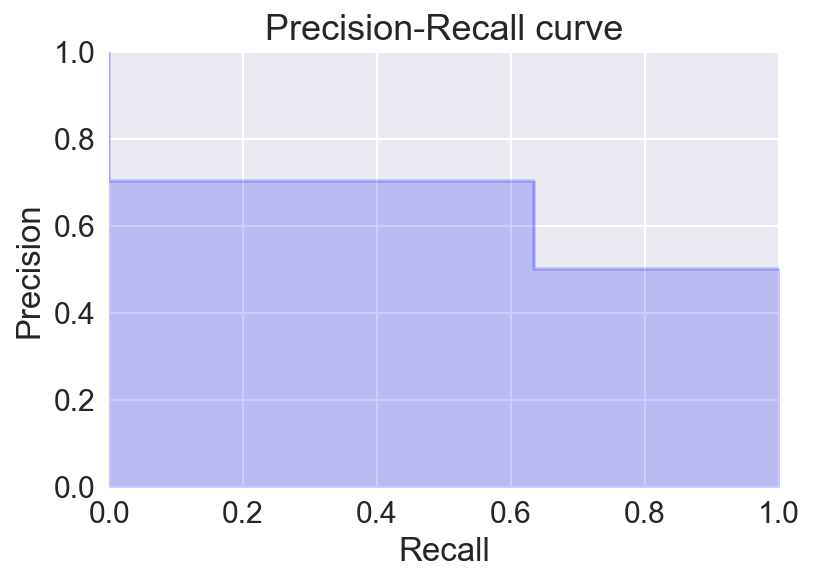

In [99]:
# Drawing the precision-recall curve for the above model

precision, recall, _  = precision_recall_curve(y_test, yhat)

plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.ylim([0.0, 1])
plt.xlim([0.0, 1]);

In [102]:
# Classification report for the above model:
print(classification_report(y_test, yhat))

             precision    recall  f1-score   support

      False       0.67      0.73      0.70        41
       True       0.70      0.63      0.67        41

avg / total       0.68      0.68      0.68        82



In [103]:
# Confusion matrix for the above model:
conmat = np.array(confusion_matrix(y_test, yhat, labels=[1,0]))
confusion = pd.DataFrame(conmat, index=['Real high salary', 'Real low salary'],
                         columns=['Predicted high salary','Predicted low salary'])
confusion

,Predicted high salary,Predicted low salary
Real high salary,26,15
Real low salary,11,30


In [116]:
# Creating a dataframe to select the threshold for a low false positive rate (fpr).
# This dataframe corresponds to the ROC curve drawn above.

th_fpr = pd.DataFrame({'threshold':threshold, 'fpr':fpr, 'tpr':tpr})
th_fpr

,threshold,fpr,tpr
0,2.000000,0.000000,0.000000
1,1.000000,0.024390,0.146341
2,0.888889,0.024390,0.195122
3,0.833333,0.073171,0.243902
4,0.822115,0.121951,0.243902
5,0.733333,0.146341,0.292683
6,0.732143,0.146341,0.317073
7,0.606452,0.195122,0.414634
8,0.577778,0.195122,0.439024
9,0.565789,0.243902,0.536585


In [129]:
# Setting positive threshold at 0.888889 to minimise false positives

y_pp = pd.DataFrame(yhat_pp, columns = ['class_0_pp','class_1_pp'])
y_pp['pred_class_thresh89'] = [1 if x >= 0.888889 else 0 for x in y_pp.class_1_pp.values]
y_pp.head(2)

,class_0_pp,class_1_pp,pred_class_thresh89
0,0.646617,0.353383,0
1,0.434211,0.565789,0


In [130]:
# Drawing a new confusion matrix for the model with the threshold at 0.888889
conmat = np.array(confusion_matrix(y_test, y_pp.pred_class_thresh89.values, labels=[1,0]))

confusion = pd.DataFrame(conmat, index=['Real high salary', 'Real low salary'],
                         columns=['Predicted high salary','Predicted low salary'])
confusion

,Predicted high salary,Predicted low salary
Real high salary,6,35
Real low salary,1,40


To summarise this section, I looked at both the ROC curve and the dataframe containing the false positive rate, true positive rate, and their respective thresholds. Because I am interested in lowering the amount of false positives, I looked at a threshold that would minimise the amount of false positives while still keeping some true positives.

As can be seen from the last confusion matrix though, this has come at a heavy price: the amount of true positives have fallen significantly, and these predictions have now turned into false negatives due to the increased threshold.

Which threshold is preferable is, of course, completely subjective, and dependent on which mistakes we consider more costly.

## Conclusions

I attempted to predict whether salaries for data science job listings on Indeed.com were above or below average (median), focusing at listings in 16 large US cities. 

To obtain the data, as a first step their website was scraped. Next, each listing’s job title, salary, location and company information were extracted and stored. The data obtained was cleaned and formatted, with the median salaries calculated from their average. 

New variables were created from the data available in the job titles. Based on keywords in job titles, jobs were classified as one of the following: junior role, senior role, very senior role, involving machine learning, involving data engineering. Note that the labels were not necessarily mutually exclusive and that a job listing (row) could have none of these attributes. 

As the junior and very senior role variables had extremely low correlation with the high/low salary variable, they were not used in any of the models. Using the rest of the new variables in conjunction with the previously mentioned city variables, a logistic regression and random forest classification were conducted. 
 
The random forest model performed the best after tuning some of the models’ parameters, obtaining an accuracy of over 68% on the test data - considerably higher than the baseline of about 0.5.

As I was interested in minimising the amount of false positive predictions being made, that is, predicting that a job is high-paying when it in reality is not, the threshold for accepting predictions as true was raised to nearly 0.89. Although reducing the amount of false positives was reduced, this has come at a price: the amount of true positives have fallen significantly, and these predictions have now turned into false negatives due to the increased threshold. 

This means that whereas the final model makes very few mistakes in labelling low-paying jobs as high-paying ones, in its carefulness the amount of true positives has also considerably fallen, reducing the usefulness of the model in identifying which jobs are high-paying based on location and the variables extracted from the job titles.